## Udacity Data Analyst Nanodegree - Project "Data Wrangling and Analyzing" ##

### Introduction ###
Using Python and its libraries, I will gather data from three sources, assess its quality and tidiness, then clean it.
The datasets:
1) The first dataset that I will be wrangling is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc.
2) Back to the basicness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API.
3) Furthermore, an Udacity employee ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

#### Gathering Data ####

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import time
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# load the twitter-archive-enhanced.csv into a DataFrame
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
twitter_archive.sort_values('timestamp')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
# download the image prediction file from Udacity's server using the requests function
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open (url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [5]:
# load the image predictions data into a DataFrame
predictions = pd.read_csv('image-predictions.tsv', sep='\t')
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# load the data Tweeter API

CONSUMER_KEY = ""
CONSUMER_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth_handler = auth,
                 parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

In [7]:
missing_tweets = []

with open ('tweet_json.txt', 'w') as file:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            start_time = time.time()
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            # writes one tweet per line
            file.write(json.dumps(tweet) + '\n')
            end_time = time.time()
            print('ID {} . Time in seconds: {}'.format(tweet_id, end_time-start_time))
        except Exception as e_message:
            missing_tweets.append(tweet_id)
            print("Error for ID: " + str(tweet_id) + str(e_message))
    print('End reached.')

ID 892420643555336193 . Time in seconds: 0.18765687942504883
ID 892177421306343426 . Time in seconds: 0.1942901611328125
ID 891815181378084864 . Time in seconds: 0.1601874828338623
ID 891689557279858688 . Time in seconds: 0.16150808334350586
ID 891327558926688256 . Time in seconds: 0.16878581047058105
ID 891087950875897856 . Time in seconds: 0.157240629196167
ID 890971913173991426 . Time in seconds: 0.18387198448181152
ID 890729181411237888 . Time in seconds: 0.18661761283874512
ID 890609185150312448 . Time in seconds: 0.15947437286376953
ID 890240255349198849 . Time in seconds: 0.16348481178283691
ID 890006608113172480 . Time in seconds: 0.20705270767211914
ID 889880896479866881 . Time in seconds: 0.15099692344665527
ID 889665388333682689 . Time in seconds: 0.15417814254760742
ID 889638837579907072 . Time in seconds: 0.18549156188964844
ID 889531135344209921 . Time in seconds: 0.1630103588104248
ID 889278841981685760 . Time in seconds: 0.1595325469970703
ID 888917238123831296 . Time i

In [9]:
missing_tweets

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 851953902622658560,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 771004394259247104,
 770743923962707968,
 759566828574212096,
 754011816964026368,
 680055455951884288]

In [57]:
# Try again to gather the missing tweets. 
missing_tweets_new = [] 

with open('tweet_json.txt', 'w') as file:
    for tweet_id in missing_tweets:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')._json
            file.write(json.dumps(tweet) + '\n')
            
        except Exception as e_message:
            print("Error for ID: " + str(tweet_id) + str(e_message))
            missing_tweets_new.append(tweet_id)

Error for ID: 888202515573088257[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 873697596434513921[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 872668790621863937[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 872261713294495745[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 869988702071779329[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 866816280283807744[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 861769973181624320[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 856602993587888130[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 851953902622658560[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 845459076796616705[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 844704788403113984[{'code': 144, 'message': 'No status found with 

In [55]:
missing_tweets_new == missing_tweets

True

In [58]:
list_for_df = []

with open('tweet_json.txt') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        tweet_id = json_data['id']
        favorite_count = json_data['favorite_count']
        retweet_count = json_data['retweet_count']
                
        list_for_df.append({'tweet_id': tweet_id,
                        'favorite_count': favorite_count,
                        'retweet_count': retweet_count})

# create a new DataFrame 
df = pd.DataFrame(list_for_df, columns = ['tweet_id', 'favorite_count', 'retweet_count'])
df.head()

# Save the dataFrame in file
df.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

#### Assessing Data ####

In [13]:
pd.set_option('display.max_colwidth', -1)

##### Dataset 1 - twitter_archive #####

In [14]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [15]:
twitter_archive.sample(6)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
952,751937170840121344,NaN,NaN,2016-07-10 00:32:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ruby. Her ice cube is melting. She doesn't know what to do about it. 11/10 https://t.co/Vfc3eAFl2q,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751937170840121344/photo/1,11,10,Ruby,None,None,None,None
576,800859414831898624,8.008580e+17,291859009.0,2016-11-22 00:32:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@SkyWilliams doggo simply protecting you from evil that which you cannot see. 11/10 would give extra pets,NaN,NaN,NaN,NaN,11,10,None,doggo,None,None,None
2006,672267570918129665,NaN,NaN,2015-12-03 04:14:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you accidentally open up the front facing camera. 10/10 https://t.co/jDXxZARQIZ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672267570918129665/photo/1,10,10,None,None,None,None,None
559,803276597545603072,NaN,NaN,2016-11-28 16:37:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Winston. His selfie game is legendary. Will steal your girl with a single snap. 11/10 handsome as h*ck https://t.co/jxQhxoPsgL,NaN,NaN,NaN,https://twitter.com/dog_rates/status/803276597545603072/photo/1,11,10,Winston,None,None,None,None
1361,703079050210877440,NaN,NaN,2016-02-26 04:48:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks https://t.co/hMjzhdUHaW,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/703079050210877440/photo/1,https://twitter.com/dog_rates/status/703079050210877440/photo/1",11,10,a,None,None,None,None
1546,689283819090870273,NaN,NaN,2016-01-19 03:10:43 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Chipson. He's aerodynamic af. No eyes (devastating). 9/10 would make sure he didn't bump into stuff https://t.co/V62rIva61J,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689283819090870273/photo/1,9,10,Chipson,None,None,None,None


There are some retweets (text begins with RT @ and there a not NaN values in the retweeted_user_id and retweeted_status_id column) and tweets/ retweets without images (expanded_urls with NaN values).

In [16]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [17]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
twitter_archive.shape

(2356, 17)

In [19]:
twitter_archive.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          0   
doggo                         0   
floofer                       0   
pupper                        0   
puppo                         0   
dtype: int64

In [20]:
twitter_archive['tweet_id'].duplicated().any()

False

In [21]:
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id         77  
in_reply_to_user_id           31  
timestamp                     2356
source                        4   
text                          2356
retweeted_status_id           181 
retweeted_status_user_id      25  
retweeted_status_timestamp    181 
expanded_urls                 2218
rating_numerator              40  
rating_denominator            18  
name                          957 
doggo                         2   
floofer                       2   
pupper                        2   
puppo                         2   
dtype: int64

In [22]:
twitter_archive['name'].value_counts()

None          745
a             55 
Charlie       12 
Cooper        11 
Oliver        11 
Lucy          11 
Penny         10 
Lola          10 
Tucker        10 
Winston       9  
Bo            9  
the           8  
Sadie         8  
Bailey        7  
Daisy         7  
an            7  
Buddy         7  
Toby          7  
Oscar         6  
Stanley       6  
Bella         6  
Koda          6  
Milo          6  
Dave          6  
Scout         6  
Rusty         6  
Jax           6  
Leo           6  
Jack          6  
Alfie         5  
             ..  
Jessiga       1  
Timofy        1  
Cecil         1  
Maude         1  
Mac           1  
Vince         1  
Alf           1  
Willie        1  
Kayla         1  
Rupert        1  
Emanuel       1  
Ike           1  
Poppy         1  
Ralf          1  
Olaf          1  
Juckson       1  
Strider       1  
Horace        1  
Damon         1  
Augie         1  
Blipson       1  
Sundance      1  
Philippe      1  
officially    1  
Amy       

In [23]:
np.sort(twitter_archive['name'].unique())

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber', 'Ambrose',
       'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel', 'Anna',
       'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen', 'Arlo',
       'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh', 'Aspen',
       'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn', 'Ava',
       'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo', 'Barclay',
       'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter', 'Bayley',
       'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo', 'Bell',
       'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny', 'Bentley',
       'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson', 'Betty', 'Beya',
       'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky', 'Birf', 'Bisquick',
       'Blakely', 'Blanket', 'Blipson', 'Blitz', 'Bloo', 'Bloop', 'Blu',

In [24]:
# the lowercase names in the 'name' column seem to be wrong, let's look at them
twitter_archive.loc[(twitter_archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,NaN,NaN,NaN,"https://twitter.com/dog

The applied algorithm seems to expect the name after specific phrases: here is, this is, say hello to and ignored "that is" before the phrase "this is", while "that is" introduces the name. ID 666287406224695296: in the text appears "3 1/2" before the actual rating, resulting in wrong rating_numerator and rating_dominator.

In [25]:

# checking the unique values of doggo, floofer, pupper and puppo column
twitter_archive['doggo'].unique(), twitter_archive['floofer'].unique(), 
twitter_archive['pupper'].unique(), twitter_archive['puppo'].unique()

(array(['None', 'pupper'], dtype=object),
 array(['None', 'puppo'], dtype=object))

In [26]:
twitter_archive.loc[(twitter_archive['doggo']== 'None') & (twitter_archive['floofer']== 'None') & (twitter_archive['pupper']== 'None') & (twitter_archive['puppo']== 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
10,8900066081

For 1976 IDs there are no dog "stage" ("doggo", "floofer", "pupper" and "puppo") information.

In [27]:
twitter_archive.loc[(twitter_archive['doggo']== 'doggo') & (twitter_archive['floofer']== 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None


ID 854010172552949760 doggo (first one is right)

In [28]:
twitter_archive.loc[(twitter_archive['doggo']== 'doggo') & (twitter_archive['pupper']== 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,Non

first dog stage information per tweet is the right one and the word 'both' is in every tweet with a rating for two dogs
ID 817777686764523521 pupper
ID 808106460588765185 two dogs
ID 802265048156610565 two dogs
ID 801115127852503040 doggo
ID 785639753186217984 doggo
ID 781308096455073793 two dogs
ID 775898661951791106 two dogs
ID 770093767776997377 two dogs
ID 759793422261743616 two dogs
ID 751583847268179968 none
ID 741067306818797568 two dogs
ID 733109485275860992 two dogs

In [29]:
twitter_archive.loc[(twitter_archive['doggo']== 'doggo') & (twitter_archive['puppo']== 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo


ID 855851453814013952 puppo (first one is right)

In [30]:
len(twitter_archive.loc[(twitter_archive['floofer']== 'floofer') & (twitter_archive['pupper']== 'pupper')])

0

In [31]:
len(twitter_archive.loc[(twitter_archive['floofer']== 'floofer') & (twitter_archive['puppo']== 'puppo')])

0

In [32]:
len(twitter_archive.loc[(twitter_archive['pupper']== 'pupper') & (twitter_archive['puppo']== 'puppo')])

0

In [33]:
# take a further look on the text column
twitter_archive['text'].iloc[1000:1030]

1000    PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q                                              
1001    Pls don't send more sherks. I don't care how seemingly floofy they are. It does me so much frighten. Thank u. 11/10 https://t.co/oQqlOsla4R 
1002    This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
1003    This is Huxley. He's pumped for #BarkWeek. Even has a hat. Ears are quite magical. 11/10 would remove hat to pat https://t.co/V7h5NMYbYz    
1004    Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R  
1005    Other pupper asked not to have his identity shared. Probably just embarrassed about the headbutt. Also 12/10 it'll be ok mystery pup        
1006    This is Keurig. He apparently headbutts other dogs to greet them. Not cool Keurig. So fluffy tho 1

Some tweets contain more than one rating (i.e., index 1007) and do not contain dog stage information (i.e., index 1026)

In [34]:
# Are there any ratings using decimal numbers?
twitter_archive[twitter_archive['text'].str.contains(r'(\d+\.\d+\/\d+)')]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


Some ratings contain decimal numbers which lead to wrong numerator and denominator ratings.

In [35]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [36]:
np.sort(twitter_archive['rating_numerator'].unique())

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   20,   24,   26,   27,   44,
         45,   50,   60,   75,   80,   84,   88,   99,  121,  143,  144,
        165,  182,  204,  420,  666,  960, 1776])

In [37]:
np.sort(twitter_archive['rating_denominator'].unique())

array([  0,   2,   7,  10,  11,  15,  16,  20,  40,  50,  70,  80,  90,
       110, 120, 130, 150, 170])

In [38]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [39]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

##### Dataset 2 - predictions #####

In [40]:

predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [41]:
predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1915,854365224396361728,https://pbs.twimg.com/media/C9tQokgUIAEETSx.jpg,1,Pembroke,0.907080,True,Cardigan,0.086272,True,Chihuahua,0.001413,True
790,690649993829576704,https://pbs.twimg.com/media/CZWugJsWYAIzVzJ.jpg,1,bighorn,0.215438,False,hyena,0.137928,False,Mexican_hairless,0.098171,True
700,684800227459624960,https://pbs.twimg.com/media/CYDmK7ZVAAI_ylL.jpg,1,miniature_schnauzer,0.294457,True,Norfolk_terrier,0.161885,True,West_Highland_white_terrier,0.120992,True
1251,747933425676525569,https://pbs.twimg.com/media/CmExV2qWkAAn_pN.jpg,1,Samoyed,0.998201,True,Eskimo_dog,0.000793,True,Great_Pyrenees,0.000296,True
908,700505138482569216,https://pbs.twimg.com/media/Cbixs3vUUAAqHHN.jpg,1,bath_towel,0.449684,False,Norwegian_elkhound,0.160205,True,Great_Dane,0.048666,True


In [42]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [43]:
predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [44]:
predictions['tweet_id'].duplicated().any()

False

In [45]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [46]:
predictions['img_num'].value_counts()

1    1780
2    198 
3    66  
4    31  
Name: img_num, dtype: int64

In [47]:
predictions['p1_dog'].value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [48]:
predictions['p2_dog'].value_counts()

True     1553
False    522 
Name: p2_dog, dtype: int64

In [49]:
predictions['p3_dog'].value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

##### Dataset 3 - twitter_add_info #####

In [52]:
twitter_add_info = pd.read_csv('tweet_json.txt')
twitter_add_info.head()

,tweet_id,favorite_count,retweet_count


In [51]:
twitter_add_info.sample(5)

ValueError: a must be greater than 0

In [62]:
twitter_add_info['tweet_id'].duplicated().any()

True

In [53]:
twitter_add_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
tweet_id          0 non-null object
favorite_count    0 non-null object
retweet_count     0 non-null object
dtypes: object(3)
memory usage: 0.0+ bytes


In [65]:
twitter_add_info.describe()

,tweet_id,favorite_count,retweet_count
count,4.105000e+03,4105.000000,4105.000000
mean,7.515053e+17,8133.091596,2869.123995
std,6.718493e+16,11880.101465,4599.458675
min,6.660209e+17,0.000000,1.000000
25%,6.881794e+17,1832.000000,662.000000
50%,7.432106e+17,3760.000000,1476.000000
75%,8.081346e+17,10229.000000,3314.000000
max,8.924206e+17,151960.000000,75089.000000


#### Quality Issues ####

##### DataFrame twitter_archive #####
* retweeted_user_id and retweeted_status_id column: there are some retweets
* expanded_urls column: tweets/ retweets without images
* timestamp: not datetime format
* name column: none appears 745 (missing data but not NaN)
* name column: some names are false (O, a, not..)
* tweet_id: is int, should be type object as no calculation is needed
* text and rating_numerator column: tweets that include more than one rating and/or decimal numbers, hence, wrong or missing data in the rating_numerator and rating_denominator column
* pupper, puppo, floofer and doggo column: For 1976 IDs there are no dog "stage" information.
* pupper, puppo, floofer and doggo column: There are some IDs with more than one dog "stage" information (two dogs are rated).
* missing column for the fraction of rating_numerator and rating_denominator

##### DataFrame predictions #####
* p1,p2,p3 columns: dog breeds are not consistently lower or uppercase
* tweet_id is int, should be type object as no calculation is needed
* img_num column does not contain new information

##### DataFrame twitter_add_info #####
* tweet_id is int, should be type object as no calculation is needed

##### Tidiness Issues #####
* twitter_archive: 4 columns (dogger, floofer, pupper and puppo) for one variable (dog stage)
* predictions: the dog breed prediction could be packed into one column (breed_pred)
* predictions: the prediction confidence could be packed into one column (pred_confidence)
* predictions: jpg_url, breed_pred and pred_confidence should be joined to twitter_archive DataFrame

#### Cleaning Data ####

In [66]:
twitter_archive_clean = twitter_archive.copy()
predictions_clean = predictions.copy()
twitter_add_info_clean = twitter_add_info.copy()

##### Starting with missing/ wrong data

###### 1. Issue: Missing / wrong data in twitter_archive's name column ######

##### Define #####

Gather the correct names from twitter_archive_clean DataFrames 'text' column by creating a function that extracts the names based on the observations made ('name is' should be regarded and 'that is' should be regarded before 'this is')

##### Code #####

In [67]:
# idea from: https://github.com/sanjeevai/Wrangle_and_Analyze_data/blob/master/wrangle_act.ipynb

twitter_archive_clean['text_split'] = twitter_archive_clean['text'].str.split()

def correct_names(case):
    # 'named'           
    if 'named' in case['text'] and re.match(r'[A-Z].*', case['text_split'][(case['text_split'].index('named') + 1)]): 
        return(case['text_split'][(case['text_split'].index('named') + 1)])
    
    # 'Here we have'
    elif case['text'].startswith('Here we have ') and re.match(r'[A-Z].*', case['text_split'][3]):
        return(case['text_split'][3].strip('.').strip(','))
    
    # 'That is'
    elif case['text'].startswith('That is ') and re.match(r'[A-Z].*', case['text_split'][2]):
        return(case['text_split'][2].strip('.').strip(','))  

    # 'Name is'
    elif case['text'].startswith('Name is ') and re.match(r'[A-Z].*', case['text_split'][2]):
        return(case['text_split'][2].strip('.').strip(','))
            
    # 'This is'
    elif case['text'].startswith('This is ') and re.match(r'[A-Z].*', case['text_split'][2]):
        return(case['text_split'][2].strip('.').strip(','))
    
    # 'Say hello to'
    elif case['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', case['text_split'][3]):
        return(case['text_split'][3].strip('.').strip(','))
    
    # 'Meet'
    elif case['text'].startswith('Meet ') and re.match(r'[A-Z].*', case['text_split'][1]):
        return(case['text_split'][1].strip('.').strip(','))
            
    else:
        return np.NaN

In [68]:
# apply the written function 
twitter_archive_clean['names'] = twitter_archive_clean.apply (lambda case: correct_names (case),axis=1)

In [69]:
# delete the created text_split column
twitter_archive_clean.drop(['text_split'], axis=1, inplace=True)

##### Test #####

In [70]:
twitter_archive_clean.loc[(twitter_archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None,NaN
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None,NaN
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None,NaN
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None,NaN
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None,NaN
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-001480161.html?sbdht=_pM1QUzk3wsdTxcmMoRPV7FWYYlsNKcFRcYSY7OmeHnOXA4NtUM6PLQ2_,10,10,not,None,None,None,None,NaN
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1,https://twitter.com/dog_rates/status/828650029636317184/photo/1",14,10,one,None,None,None,None,NaN
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024703037440/photo/1,11,10,incredibly,None,None,None,None,NaN
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wf

###### 2. Issue: Missing / wrong data in twitter_archive's pupper, puppo, floofer and doggo column ######

##### Define #####

Gather the correct dog "stage" information out of twittcher_archive_clean's 'text' column (NaN if the word 'both' appears in a tweet indacting that two dogs were rated and looking for the words puppo, doggo, pupper and floofer).

##### Code #####

In [71]:
twitter_archive_clean['dog_stage'] = twitter_archive_clean['text'].str.lower().map(lambda x: 
                                                                                   np.NaN if "both" in x 
                                                                                   else "puppo" if "puppo" in x 
                                                                                   else "doggo" if "doggo" in x 
                                                                                   else "pupper" if "pupper" in x 
                                                                                   else "floofer" if "floofer" in x 
                                                                                   else np.NaN)
# this code does apply in most cases, but it does not regard the order of occurrence of the words (if doggo occurs before 
# pupper the dog stage will be doggo even if pupper is the meant dog stage and doggo is only a part of a word like "didodoggo"
# for ID 817777686764523521). As there's only one case in this dataset where the function does not work properly I will change
# the dog_stage for this ID manually to pupper.

In [72]:
# change dog_stage for ID 817777686764523521 from doggo to pupper
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 817777686764523521, 'dog_stage'] = 'pupper'

In [73]:
# change dog_stage type to category
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')

##### Test #####

In [74]:
 # the dog_stage should be pupper now
twitter_archive_clean.loc[(twitter_archive_clean['doggo']== 'doggo') & (twitter_archive_clean['pupper']== 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None,Dido,pupper
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None,Burke,NaN
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None,NaN,NaN
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None,Bones,doggo
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None,Pinot,doggo
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None,NaN,NaN
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None,NaN,NaN
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None,NaN,NaN
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/p

In [75]:
# the dog_stage should be puppo now
twitter_archive_clean.loc[(twitter_archive_clean['doggo']== 'doggo') & (twitter_archive_clean['puppo']== 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo,NaN,puppo


In [76]:
# the dog_stage should be doggo now
twitter_archive_clean.loc[(twitter_archive_clean['doggo']== 'doggo') & (twitter_archive_clean['floofer']== 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None,NaN,doggo


In [77]:
twitter_archive_clean['dog_stage'].unique()

[NaN, doggo, puppo, pupper, floofer]
Categories (4, object): [doggo, puppo, pupper, floofer]

In [78]:
twitter_archive_clean['dog_stage'].dtype

CategoricalDtype(categories=['doggo', 'floofer', 'pupper', 'puppo'], ordered=False)

###### 3. Issue: Missing / wrong data in twitter_archive's rating_numerator column ######

##### Code #####
Extract the correct rating using regular expressions, regarding that some ratings include decimal numbers and some tweets include ratings for two dogs (treat them as NaNs).

##### Test #####

In [79]:
# https://github.com/kdow/WeRateDogs/blob/master/wrangle_act.ipynb
# find all tweets with more than one rating
id_list_double_rating = twitter_archive_clean['tweet_id'][twitter_archive_clean.text.str.contains
                                              ( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].tolist()
id_list_double_rating

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


[881633300179243008,
 835246439529840640,
 802624713319034886,
 777684233540206592,
 775096608509886464,
 763167063695355904,
 747600769478692864,
 740373189193256964,
 722974582966214656,
 716439118184652801,
 714258258790387713,
 703356393781329922,
 695064344191721472,
 694352839993344000,
 691483041324204033,
 690400367696297985,
 689835978131935233,
 682962037429899265,
 677314812125323265,
 676191832485810177,
 674737130913071104,
 674646392044941312,
 673295268553605120,
 672248013293752320,
 671154572044468225,
 670434127938719744,
 669037058363662336,
 668537837512433665,
 667544320556335104,
 667491009379606528,
 667070482143944705,
 666835007768551424,
 666287406224695296]

In [80]:
# create a new column for the corrected rating_numerator
twitter_archive_clean['rating_numerator_new'] = twitter_archive_clean['rating_numerator']

# replace false rating_numerator values with NaN for all tweets with double ratings
twitter_archive_clean['rating_numerator_new'] = np.where(twitter_archive_clean['tweet_id'].isin(id_list_double_rating),
                                                         np.NaN, twitter_archive_clean['rating_numerator_new'])

# there should be 33 NaN values
twitter_archive_clean['rating_numerator_new'].isnull().sum()

33

In [81]:
# change rating_numerator_new type from object to float
twitter_archive_clean['rating_numerator_new'] = pd.to_numeric(twitter_archive_clean['rating_numerator_new'])
twitter_archive_clean['rating_numerator_new'].dtype

dtype('float64')

In [82]:

twitter_archive_clean['rating_numerator_new'].dtype

dtype('float64')

In [83]:
# find all tweets with decimal numerators
twitter_archive_clean[twitter_archive_clean.text.str.contains( r'(\d+\.\d+)/(\d+)')]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage,rating_numerator_new
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,Bella,NaN,5.0
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,NaN,NaN,75.0
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,Logan,NaN,75.0
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,Sophie,pupper,27.0
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None,NaN,NaN,5.0
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,NaN,pupper,26.0


In [84]:
id_list = twitter_archive_clean['tweet_id'][twitter_archive_clean.text.str.contains( r'(\d+\.\d+)/(\d+)')].tolist()
id_list

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


[883482846933004288,
 832215909146226688,
 786709082849828864,
 778027034220126208,
 681340665377193984,
 680494726643068929]

In [85]:
# create a list with the decimal ratings 
num_list = twitter_archive_clean['text'].str.extract( r'(\d+\.\d+)/(\d+)')[0].dropna().tolist()
num_list

['13.5', '9.75', '9.75', '11.27', '9.5', '11.26']

In [86]:

# create a dictionary
my_dict = dict(zip(id_list, num_list))
my_dict

{883482846933004288: '13.5',
 832215909146226688: '9.75',
 786709082849828864: '9.75',
 778027034220126208: '11.27',
 681340665377193984: '9.5',
 680494726643068929: '11.26'}

In [87]:
# use the created dictionary to change the wrong rating numerators with the right one in the dictionary 
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'].isin(my_dict.keys()), 'rating_numerator_new'] = twitter_archive_clean['tweet_id'].map(my_dict)

##### Test #####

In [88]:
twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']!=twitter_archive_clean['rating_numerator_new']]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage,rating_numerator_new
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,Bella,NaN,13.5
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None,NaN,NaN,NaN
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None,NaN,NaN,NaN
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,NaN,NaN,9.75
561,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,"https://twitter.com/dog_rates/status/777684233540206592/photo/1,https://twitter.com/dog_rates/status/777684233540206592/photo/1",12,10,None,None,None,None,None,NaN,NaN,NaN
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,Logan,NaN,9.75
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,Sophie,pupper,11.27
766,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233540206592/photo/1,12,10,None,None,None,None,None,NaN,NaN,NaN
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/74

In [89]:
twitter_archive_clean[twitter_archive_clean.text.str.contains( r'(\d+\.\d+)/(\d+)')]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage,rating_numerator_new
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,Bella,NaN,13.5
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,NaN,NaN,9.75
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,Logan,NaN,9.75
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,Sophie,pupper,11.27
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None,NaN,NaN,9.5
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,NaN,pupper,11.26


#### Tidiness issues ####

##### Issue 4: the dog breed prediction and prediction confidence could be each packed into one column #####

##### Define #####
Create a new colum (breed_pred) for the predicted dog breed (if the first prediction wasn't a dog breed, take the second and so on) and the confidence of the prediction as a second column

##### Code #####

In [92]:
# write a function that extracts the first dog breed prediction from the predictions DataFrame
def breed(row):
    if row['p1_dog']:
        return(row['p1'])
    elif row['p2_dog']:
        return(row['p2'])
    elif row['p3_dog']:
        return(row['p3'])
    else:
        return(np.NaN)

In [93]:
# apply the breed function to the clean DataFrame to create a new column 'breed_pred'
complete_df_clean['breed_pred'] = complete_df_clean.apply (lambda row: breed (row),axis=1)

In [94]:
# write a function that extracts the confidence for the first dog breed prediction from the predictions DataFrame
def confidence(row):
    if row['p1_dog']:
        return(row['p1_conf'])
    elif row['p2_dog']:
        return(row['p2_conf'])
    elif row['p3_dog']:
        return(row['p3_conf'])
    else:
        return(np.NaN)

In [95]:
# apply the confidence function to the clean DataFrame to create a new column 'pred_confidence'
complete_df_clean['pred_confidence'] = complete_df_clean.apply (lambda row: confidence(row),axis=1)

In [96]:
complete_df_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,breed_pred,pred_confidence
353,849412302885593088,NaN,NaN,2017-04-05 00:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Noosh. He noticed you were in the shower and thought you could use some company. 12/10 h*ckin loyal https://t.co/Uq3ChFgWA3,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/849412302885593088/photo/1,https://twitter.com/dog_rates/status/849412302885593088/photo/1,https://twitter.com/dog_rates/status/849412302885593088/photo/1,https://twitter.com/dog_rates/status/849412302885593088/photo/1",...,crossword_puzzle,0.017934,False,Chihuahua,0.016191,True,15281,2985,schipperke,0.907559
1699,742465774154047488,NaN,NaN,2016-06-13 21:16:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Was just informed about this hero pupper and others like her. Another 14/10, would be an absolute honor to pet https://t.co/hBTzPmj36Z",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/742465774154047488/photo/1,https://twitter.com/dog_rates/status/742465774154047488/photo/1",...,comic_book,0.000439,False,desktop_computer,0.000268,False,7060,3783,NaN,NaN
1339,767122157629476866,NaN,NaN,2016-08-20 22:12:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rupert. You betrayed him with bath time but he forgives you. Cuddly af 13/10 https://t.co/IEARC2sRzC,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/767122157629476866/photo/1,https://twitter.com/dog_rates/status/767122157629476866/photo/1",...,miniature_poodle,0.059192,True,Irish_terrier,0.035306,True,10015,2799,toy_poodle,0.873841
3472,667806454573760512,NaN,NaN,2015-11-20 20:47:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Filup. He is overcome with joy after finally meeting his father. 10/10 https://t.co/TBmDJXJB75,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667806454573760512/photo/1,...,Chihuahua,0.187155,True,Brabancon_griffon,0.112799,True,985,449,Chihuahua,0.187155
3236,672245253877968896,NaN,NaN,2015-12-03 02:45:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Snickers. He's adorable. Also comes in t-shirt mode. 12/10 I would aggressively caress Snickers https://t.co/aCRKDaFmVr,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672245253877968896/photo/1,...,badger,0.178546,False,toy_terrier,0.037103,True,639,143,Chihuahua,0.718944
1943,718971898235854848,NaN,NaN,2016-04-10 01:20:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sadie. She is prepared for battle. 10/10 https://t.co/JRckDkZVRT,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718971898235854848/photo/1,...,Saint_Bernard,0.118769,True,Labrador_retriever,0.075492,True,3364,1037,golden_retriever,0.140394
1609,748346686624440324,NaN,NaN,2016-06-30 02:45:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""So... we meat again"" (I'm so sorry for that pun I couldn't resist pls don't unfollow) 10/10 https://t.co/XFBrrqapZa",NaN,NaN,NaN,https://twitter.com/dog_rates/status/748346686624440324/photo/1,...,whippet,0.231428,True,Saluki,0.058261,True,5094,1196,borzoi,0.596455
1013,793226087023144960,NaN,NaN,2016-10-31 23:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Juno. She spooked me up real good, but only to get my attention. Above average handwriting for a dog I think. 11/10 https://t.co/hFxxBCWlwj",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/793226087023144960/photo/1,https://twitter.com/dog_rates/status/793226087023144960/photo/1,https://twitter

#### Now adressing the remaining quality issues ####
##### Issue 6: there are some retweets (hence, duplicates) in twitter_archive_clean #####

##### Define #####
Delete all rows where retweeted_user_id is not null.

##### Code #####

In [97]:
complete_df_clean = complete_df_clean[complete_df_clean['retweeted_status_id'].isnull()]

##### Test #####

In [98]:

len(complete_df_clean[complete_df_clean['retweeted_status_id'].isnull() == False])

0

##### Issue 7: wrong format for the datetime column #####
##### Define #####
Change the timestamp column to datetime format

##### Code #####

In [100]:
complete_df_clean['timestamp'] = pd.to_datetime(complete_df_clean['timestamp'])

##### Test #####

In [101]:
complete_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3434 entries, 0 to 3575
Data columns (total 35 columns):
tweet_id                      3434 non-null int64
in_reply_to_status_id         38 non-null float64
in_reply_to_user_id           38 non-null float64
timestamp                     3434 non-null datetime64[ns]
source                        3434 non-null object
text                          3434 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 3434 non-null object
rating_numerator              3434 non-null int64
rating_denominator            3434 non-null int64
name                          3434 non-null object
doggo                         3434 non-null object
floofer                       3434 non-null object
pupper                        3434 non-null object
puppo                         3434 non-null object
names                         

##### Issue 8: drop unnecessary columns #####
##### Define #####
Drop the columns pupper, puppo, doggo and floofer from the merged dataframe 
##### Code #####

In [102]:
columns = ['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id', 
           'retweeted_status_timestamp','expanded_urls', 'name', 'doggo', 'floofer', 'pupper', 'puppo', 
           'img_num', 'rating_numerator', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
complete_df_clean.drop(columns, axis =1, inplace=True)

##### Test #####

In [103]:
columns in list(complete_df_clean)

False

##### Issue 9: missing column for the fraction of rating_numerator and rating_denominator #####
##### Define #####
Create a new column for the fraction of rating_numerator and rating_denominator
##### Code #####

In [104]:

complete_df_clean['fraction'] = complete_df_clean['rating_numerator_new'].astype(float)/complete_df_clean['rating_denominator']

##### Test #####

In [105]:
complete_df_clean['fraction'].value_counts()

1.200000      847
1.100000      718
1.000000      658
1.300000      499
0.900000      232
0.800000      130
0.700000      74 
1.400000      70 
0.600000      45 
0.500000      40 
0.300000      27 
0.400000      21 
0.200000      11 
0.100000      4  
0.000000      4  
3.428571      2  
1.350000      2  
0.975000      2  
1.127000      2  
1.126000      2  
177.600000    2  
42.000000     1  
Name: fraction, dtype: int64

##### Issue 10: dog breeds are not consistently lower or upper case #####
##### Define #####
Change the strings to lowercase (breed_pred column)
##### Code #####

In [106]:
complete_df_clean['breed_pred'] = complete_df_clean['breed_pred'].str.lower()

##### Test #####

In [107]:
complete_df_clean['breed_pred'].str.isupper().any()

False

##### Issue 11: wrong format for tweet_id #####
##### Define #####
Change Tweet_id int to str (object)
##### Code #####

In [108]:
complete_df_clean['tweet_id'] = complete_df_clean['tweet_id'].astype('str')

In [109]:
complete_df_clean['tweet_id'].dtype

dtype('O')

##### Test #####

In [110]:
complete_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3434 entries, 0 to 3575
Data columns (total 14 columns):
tweet_id                3434 non-null object
timestamp               3434 non-null datetime64[ns]
source                  3434 non-null object
text                    3434 non-null object
rating_denominator      3434 non-null int64
names                   2407 non-null object
dog_stage               602 non-null category
rating_numerator_new    3393 non-null object
jpg_url                 3434 non-null object
favorite_count          3434 non-null int64
retweet_count           3434 non-null int64
breed_pred              2942 non-null object
pred_confidence         2942 non-null float64
fraction                3393 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 379.1+ KB


##### Issue 12: delete http code from source column #####
##### Define #####
using regular expressions to delete the http code from the source column

##### Code #####

In [111]:
# https://github.com/tkannab/Udacity-DAND-T2-P3-DW/blob/master/wrangle_act.ipynb
complete_df_clean['source'] = complete_df_clean['source'].str.extract('(<a href="https?)(:\/\/)(.+)(">)(.+)(<\/a)', 
                                                                       expand = True)[4];
complete_df_clean['source'] = complete_df_clean['source'].astype('category')

##### Test #####

In [113]:
complete_df_clean['source'].value_counts()

Twitter for iPhone    3378
Twitter Web Client    36  
TweetDeck             20  
Name: source, dtype: int64

### Storing Data ###

In [114]:
complete_df_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

### Analyzing Data ###

In [115]:
plt.rcParams['figure.figsize'] = (14,7)

In [116]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 14 columns):
tweet_id                3434 non-null int64
timestamp               3434 non-null object
source                  3434 non-null object
text                    3434 non-null object
rating_denominator      3434 non-null int64
names                   2407 non-null object
dog_stage               602 non-null object
rating_numerator_new    3393 non-null float64
jpg_url                 3434 non-null object
favorite_count          3434 non-null int64
retweet_count           3434 non-null int64
breed_pred              2942 non-null object
pred_confidence         2942 non-null float64
fraction                3393 non-null float64
dtypes: float64(3), int64(4), object(7)
memory usage: 375.7+ KB


In [117]:
#change dtype source to category, timestamp to datetime, and tweet_id to object
df['source'] = df['source'].astype('category')
df['tweet_id'] = df['tweet_id'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])

##### Histograms of the variables #####

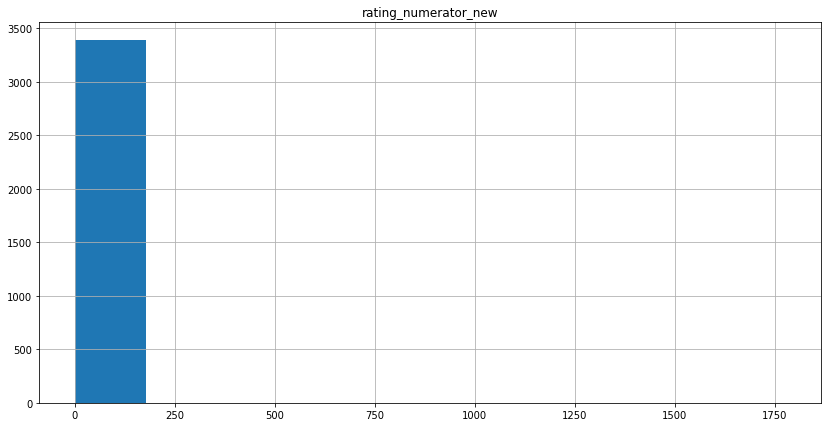

In [122]:
df.hist(column='rating_numerator_new');

We can't see the distribution of the bulk of the data as the 75% is 12 and the maximum is 1776.

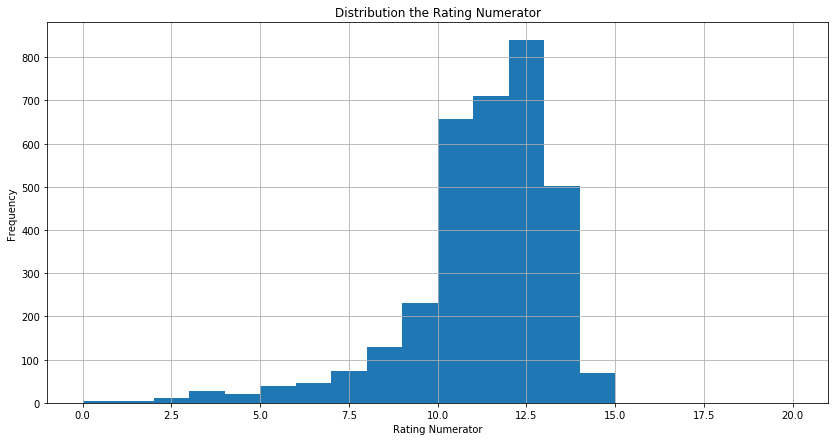

In [123]:

df.hist(column='rating_numerator_new', bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.title('Distribution the Rating Numerator')
plt.savefig('rating_numerator_dist');

The majority of rating numerators is between 10 an 12.

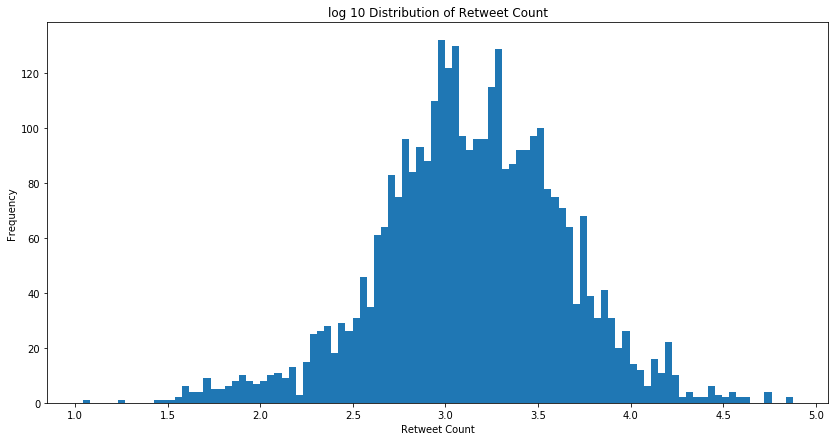

In [124]:
log_retweet = df['retweet_count'].apply(lambda x: np.log10(x))
plt.hist(log_retweet, bins=100)
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')
plt.title('log 10 Distribution of Retweet Count')
plt.savefig('retweet_count_dist');

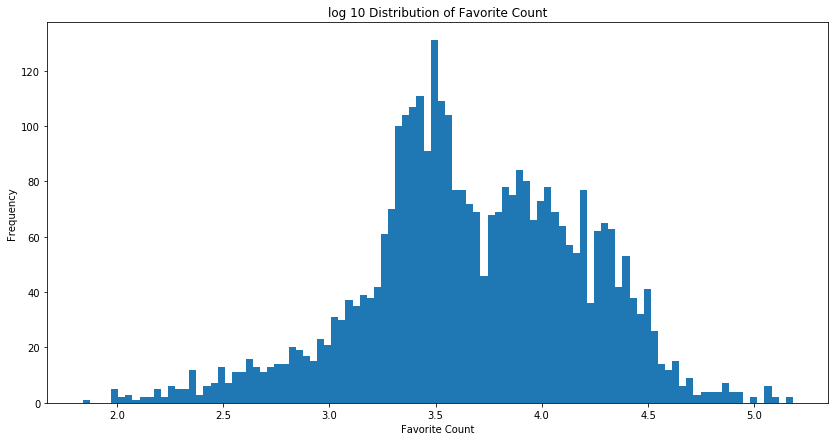

In [125]:
log_favorite = df['favorite_count'].apply(lambda x: np.log10(x))
plt.hist(log_favorite, bins=100)
plt.xlabel('Favorite Count')
plt.ylabel('Frequency')
plt.title('log 10 Distribution of Favorite Count')
plt.savefig('favorite_count_dist');

Both distribution follow a normal distribution.

##### What is the most used source? #####

In [126]:
df['source'].value_counts()

Twitter for iPhone    3378
Twitter Web Client    36  
TweetDeck             20  
Name: source, dtype: int64

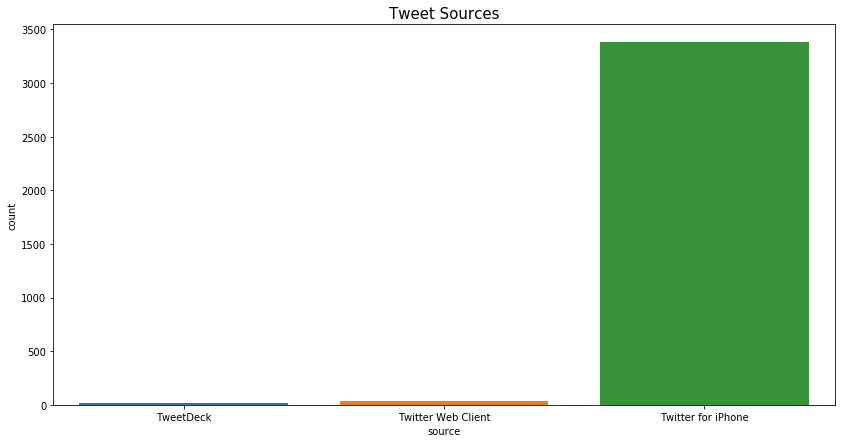

In [127]:

sns.countplot(data=df, x='source')
plt.title('Tweet Sources', size=15)
plt.savefig('most_used_twitter_source');

As we see from the graph above,  the most popular source is Twitter for iPhone followed by the Twitter Web Client and TweetDeck.

##### What are the 10 most frequent predicted dog breeds? #####

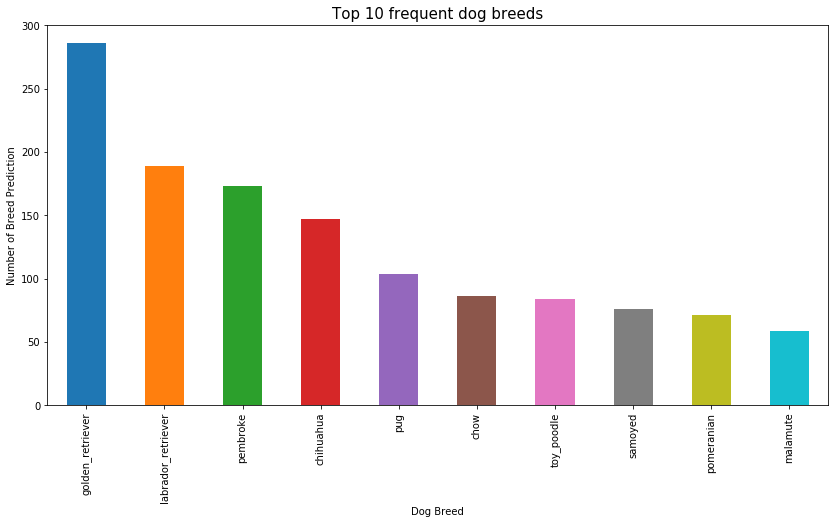

In [129]:
df['breed_pred'].value_counts()[0:10].sort_values(ascending=False).plot(kind = 'bar')
plt.ylabel('Number of Breed Prediction')
plt.title('Top 10 frequent dog breeds', size=15)
plt.xlabel('Dog Breed')
plt.savefig('most_frequent_breed');

In [130]:
df['breed_pred'].value_counts()[0:10]

golden_retriever      286
labrador_retriever    189
pembroke              173
chihuahua             147
pug                   104
chow                  86 
toy_poodle            84 
samoyed               76 
pomeranian            71 
malamute              59 
Name: breed_pred, dtype: int64

##### How confident was the algorithm for these top 10 breeds? #####

In [131]:
# create a list of top 10 names
name_list = df['breed_pred'].value_counts()[0:10].index.tolist()
name_list

['golden_retriever',
 'labrador_retriever',
 'pembroke',
 'chihuahua',
 'pug',
 'chow',
 'toy_poodle',
 'samoyed',
 'pomeranian',
 'malamute']

The most frequent predicted breed was golden retriever with 286 predictions.

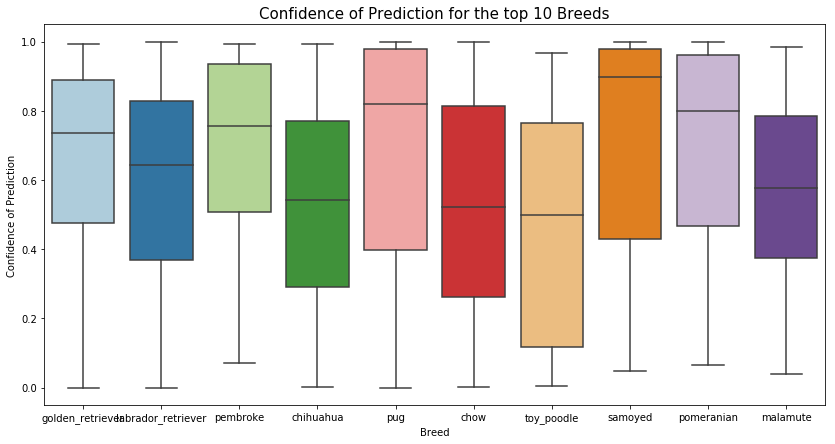

In [132]:
# use the name_list to subset the DataFrame
df_subset = df[df['breed_pred'].isin(name_list)]

# plot a boxplot using this subset
sns.boxplot(x='breed_pred', y='pred_confidence', data=df_subset, order=name_list, palette='Paired')
plt.title('Confidence of Prediction for the top 10 Breeds', size=15)
plt.xlabel('Breed')
plt.ylabel('Confidence of Prediction')
plt.savefig('prediction_confidence_top_10');

These are the top 10 predicted breeds with the corresponding confidence for their prediction. Clearly, the confidence varies between these dog breeds. For some breeds, the algorithm was pretty sure (i.e., pug, pomeranian, samoyed) and for others rather unsure (median confidence around 50%), like for chihuahua and toy_poodle.

##### What is the most frequent reported dog stage? #####

In [133]:
df['dog_stage'].value_counts()

pupper     396
doggo      136
puppo      56 
floofer    14 
Name: dog_stage, dtype: int64

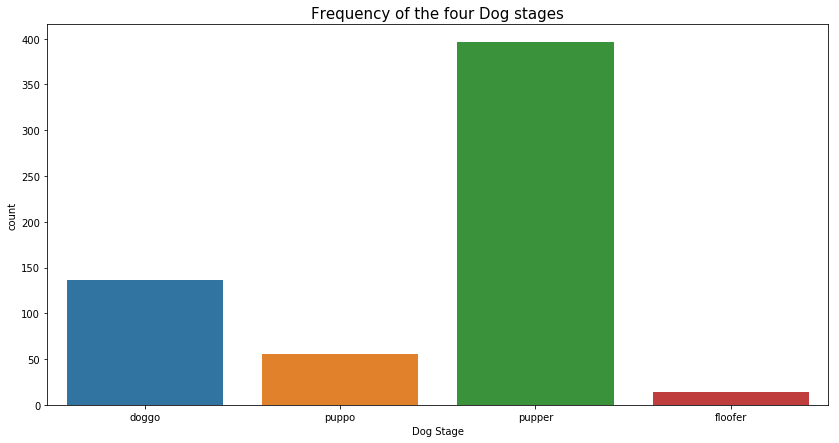

In [134]:
sns.countplot(data=df, x='dog_stage')
plt.title('Frequency of the four Dog stages', size=15)
plt.xlabel('Dog Stage')
plt.savefig('dog_stages')

Pupper is the most frequent reported dog stage (396), followed by doggo (136), puppo (56) and floofer (14).

##### Which dog stage received the highest rating? #####

In [135]:
df.groupby('dog_stage')['fraction'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,136.0,1.161765,0.169557,0.5,1.100,1.20,1.3,1.4
floofer,14.0,1.200000,0.110940,1.0,1.125,1.20,1.3,1.3
pupper,394.0,1.070320,0.177885,0.3,1.000,1.10,1.2,1.4
puppo,56.0,1.214286,0.119740,0.9,1.200,1.25,1.3,1.4


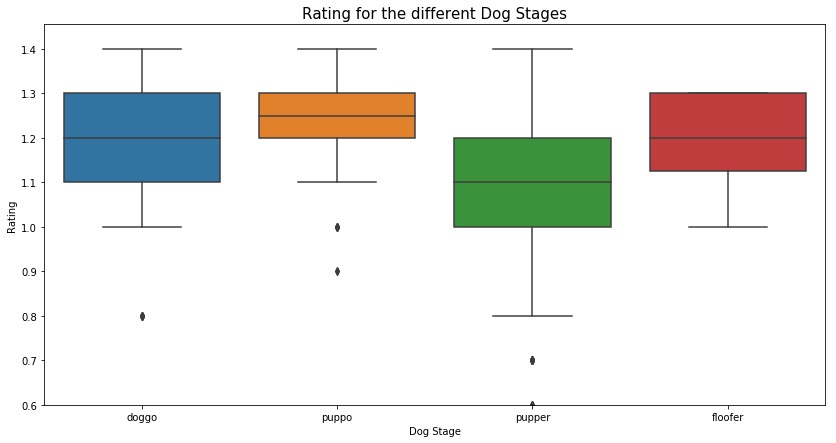

In [136]:
sns.boxplot(x='dog_stage', y='fraction', data=df)
plt.title('Rating for the different Dog Stages', size=15)
plt.xlabel('Dog Stage')
plt.ylabel('Rating')
plt.ylim(0.6,)
plt.savefig('rating_dog_stage');

Dogs with the dog stage "puppo" got the highest, dogs with the dog stage "pupper" the lowest average rating whereas "pupper" is by far the most often appearing dog stage. To get a high rating, it might help to be a "puppo" or "floofer".

##### Which dog stage received the most retweets and which the most favorites? #####

In [138]:
# retweet and favorite count depending on the dog stage
print('The mean Retweet Count for doggos is {}.'.format((round(df.retweet_count[df.dog_stage == 'doggo'].mean()))))
print('The mean Favorite Count for doggos is {}.'.format((round(df.favorite_count[df.dog_stage == 'doggo'].mean()))))
print('---'*20)
print('The mean Retweet Count for floofers is {}.'.format((round(df.retweet_count[df.dog_stage == 'floofer'].mean()))))
print('The mean Favorite Count for floofers is {}.'.format((round(df.favorite_count[df.dog_stage == 'floofer'].mean()))))
print('---'*20)
print('The mean Retweet Count for puppos is {}.'.format((round(df.retweet_count[df.dog_stage == 'puppo'].mean()))))
print('The mean Favorite Count for puppos is {}.'.format((round(df.favorite_count[df.dog_stage == 'puppo'].mean()))))
print('---'*20)
print('The mean Retweet Count for puppers is {}.'.format((round(df.retweet_count[df.dog_stage == 'pupper'].mean()))))
print('The mean Favorite Count for puppers is {}.'.format((round(df.favorite_count[df.dog_stage == 'pupper'].mean()))))

The mean Retweet Count for doggos is 5561.0.
The mean Favorite Count for doggos is 16592.0.
------------------------------------------------------------
The mean Retweet Count for floofers is 4200.0.
The mean Favorite Count for floofers is 11740.0.
------------------------------------------------------------
The mean Retweet Count for puppos is 5809.0.
The mean Favorite Count for puppos is 21148.0.
------------------------------------------------------------
The mean Retweet Count for puppers is 2110.0.
The mean Favorite Count for puppers is 6939.0.


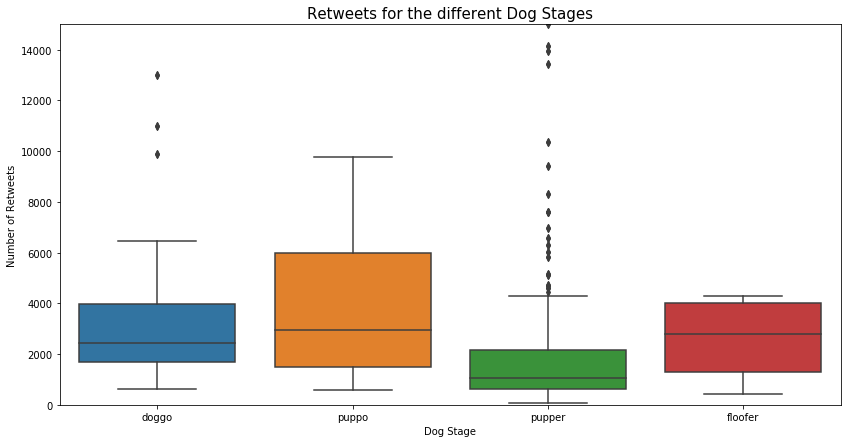

In [139]:
sns.boxplot(x='dog_stage', y='retweet_count', data=df)
plt.title('Retweets for the different Dog Stages', size=15)
plt.xlabel('Dog Stage')
plt.ylabel('Number of Retweets')
plt.ylim(0,15000)
plt.savefig('retweets_dog_stage');

Puppos and Floofers are the most retweeted and favorited dog stages. Overall, pupper is the least retweeted and favorited dog stage.


#### References ####
https://stackoverflow.com/questions/29902714/print-the-complete-string-of-a-pandas-dataframe

https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

https://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file

https://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers

https://en.wikipedia.org/wiki/WeRateDogs

https://stackoverflow.com/questions/45184549/python-pandas-new-columns-value-if-the-item-is-in-the-list

https://stackoverflow.com/questions/51782443/np-where-do-nothing-if-condition-fails

https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe

https://github.com/sanjeevai/Wrangle_and_Analyze_data/blob/master/wrangle_act.ipynb

https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

https://github.com/kdow/WeRateDogs/blob/master/wrangle_act.ipynb

https://stackoverflow.com/questions/35919907/replace-some-specific-values-in-pandas-column-based-on-conditions-in-other-colum

https://github.com/tkannab/Udacity-DAND-T2-P3-DW/blob/master/wrangle_act.ipynb

https://stackoverflow.com/questions/47252508/jupyter-notebook-figure-size-settings

https://stackoverflow.com/questions/42574379/python-sorting-dates-after-counting-them-in-pandas

https://stackoverflow.com/questions/47408527/seaborn-countplot-display-only-n-most-frequent-categories

https://stackoverflow.com/questions/47408527/seaborn-countplot-display-only-n-most-frequent-categories